In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

import datasets
from layers import relu, conv, dense, max_pool, flatten

In [2]:
#load data set
train_set, test_set = datasets.load_Cifar_10()
train_x, train_y = train_set
test_x, test_y = test_set

set_mean  = np.mean(train_x)
set_sigma = np.std(train_x)

def normalize(Xs):
    #normalize by training data mean and sigma
    Xs = (Xs - set_mean)/set_sigma
    return Xs

loading Cifar_10 training images...
loading Cifar_10 test images...


In [3]:
#model
x = tf.placeholder(tf.float32, [None, 32*32*3],'X')
x_im = tf.reshape(x, shape=[-1, 32, 32, 3])

y = tf.placeholder(tf.int32, (None, 10))

conv1 = relu(conv(x_im,n_out=64,ksize=5))
conv1 = max_pool(conv1, ksize=3, stride=2)
conv2 = relu(conv(conv1, n_out=64, ksize=5))
conv2 = max_pool(conv2, ksize=3, stride=2)
flat = flatten(conv2)
dense1 = relu(dense(flat, 384))
dense2 = relu(dense(dense1, 192))
logits = dense(dense2, 10)

4096


# Inception module

In [19]:
def inception_module(tensor, n_out, n_reduce=16):
    #1x1 conv
    conv_1x1_1 = conv(tensor, n_out, ksize=1)
    
    #3x3 conv
    #conv_1x1_2 = relu(conv(tensor, n_reduce, ksize=1))
    conv_3x3 = conv(conv_1x1_1, n_out, ksize=3)
    
    #5x5 conv
    #conv_1x1_3 = relu(conv(tensor, n_reduce, ksize=1))
    conv_5x5 = conv(conv_1x1_1, n_out, ksize=5)
    
    #Max pool
    maxpool = max_pool(tensor, ksize=3, stride=1)
    conv_1x1_4 = conv(maxpool, n_out, ksize=1)
    
    #Concatinate
    concat = tf.concat([conv_1x1_1,conv_3x3,conv_5x5,conv_1x1_4], axis=3)
    return relu(concat)


In [20]:
#Inception model
batch_size = 50

x = tf.placeholder(tf.float32, [None, 32*32*3],'X')
x_im = tf.reshape(x, shape=[-1, 32, 32, 3])

y = tf.placeholder(tf.int32, (None, 10))


incep1 = inception_module(x_im, n_out=16, n_reduce=8)
incep2 = inception_module(incep1, n_out=16, n_reduce=8)

flat = flatten(incep2)

dense1 = relu(dense(flat, n_out=700))
keepprob = tf.Variable(tf.constant(0.5), trainable=False)
keep5 = tf.assign(keepprob, 0.5)
keep1 = tf.assign(keepprob, 1)
dense1 = tf.nn.dropout(dense1, keep_prob=keepprob)

logits = dense(dense1, n_out=10)




65536


In [21]:
#loss function
rate = 0.001

l2_loss = tf.reduce_sum(tf.get_collection('l2_losses'))

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy) + 0.002*l2_loss
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
train_step = optimizer.minimize(loss_operation)

#Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

init = tf.global_variables_initializer()

#run epoch
def run_epoch(xs, ys, train=True, batch_size=128, augment=True):
    avg_loss = 0.
    avg_acc = 0.
    for batch_xs, batch_ys in datasets.batches(xs, ys, batch_size=batch_size):
        if len(batch_xs) != batch_size:
            continue
        batch_xs = normalize(batch_xs)
        feed_dict = {x: batch_xs, y: batch_ys}
        if train:
            opt, loss, acc = sess.run((train_step,loss_operation,accuracy_operation),
                                     feed_dict=feed_dict)
        else:
            loss, acc = sess.run((loss_operation, accuracy_operation),
                                feed_dict=feed_dict)
        n = len(xs)
        n_batch = len(batch_xs)
        avg_loss += loss / n * n_batch
        avg_acc += acc / n * n_batch
    return avg_loss, avg_acc

In [6]:
sess = tf.Session()

In [ ]:
%%time
training_epochs = 20
display_step = 1

#sess.run(init)
#val_losses = []
#losses = []
#val_accs = []
#accs = []
for epoch in range(1,training_epochs):
    sess.run(keep5)
    train_loss, train_acc = run_epoch(train_x, train_y, batch_size=50)
    sess.run(keep1)
    val_loss, val_acc = run_epoch(test_x, test_y, train=False, batch_size=50)
    
    val_losses.append(val_loss)
    losses.append(train_loss)
    val_accs.append(val_acc)
    accs.append(train_acc)
    
    l2 = sess.run(l2_loss)
    
    #Display every 'display_step' steps
    if epoch % display_step == 0:
        print ("EPOCH: %04d, LOSS: %.5f, ACC: %.5f, VAL_LOSS: %.5f, VAL_ACC: %.5f, l2: %.5f" % 
                   (epoch+1, train_loss, train_acc, val_loss, val_acc, l2))
if epoch % display_step == 0:
    print ("EPOCH: %04d, LOSS: %.5f, ACC: %.5f, VAL_LOSS: %.5f, VAL_ACC: %.5f" % 
                (epoch+1, train_loss, train_acc, val_loss, val_acc))

plt.figure(figsize=(15,3))
plt.subplot(121)
plt.plot(losses)
plt.plot(val_losses)
plt.subplot(122)
plt.plot(accs)
_ = plt.plot(val_accs)

EPOCH: 0002, LOSS: 2.76168, ACC: 0.47844, VAL_LOSS: 2.03398, VAL_ACC: 0.51260, l2: 340.79828
EPOCH: 0003, LOSS: 2.02541, ACC: 0.51264, VAL_LOSS: 1.87118, VAL_ACC: 0.55390, l2: 308.02704
EPOCH: 0004, LOSS: 1.93946, ACC: 0.53354, VAL_LOSS: 1.81727, VAL_ACC: 0.56390, l2: 296.90463
EPOCH: 0005, LOSS: 1.89212, ACC: 0.54852, VAL_LOSS: 1.77223, VAL_ACC: 0.58100, l2: 295.60883
EPOCH: 0006, LOSS: 1.83451, ACC: 0.56032, VAL_LOSS: 1.75420, VAL_ACC: 0.58170, l2: 287.71295
EPOCH: 0007, LOSS: 1.79819, ACC: 0.57046, VAL_LOSS: 1.72725, VAL_ACC: 0.59360, l2: 290.75711
EPOCH: 0008, LOSS: 1.78862, ACC: 0.57938, VAL_LOSS: 1.67986, VAL_ACC: 0.60840, l2: 280.09555
EPOCH: 0009, LOSS: 1.75296, ACC: 0.58640, VAL_LOSS: 1.69150, VAL_ACC: 0.60950, l2: 292.63345
EPOCH: 0010, LOSS: 1.75006, ACC: 0.59094, VAL_LOSS: 1.65850, VAL_ACC: 0.61360, l2: 286.09070
EPOCH: 0011, LOSS: 1.73389, ACC: 0.59476, VAL_LOSS: 1.67536, VAL_ACC: 0.61910, l2: 290.37259
EPOCH: 0012, LOSS: 1.73253, ACC: 0.59488, VAL_LOSS: 1.67111, VAL_ACC: 

In [ ]:
%%time
training_epochs = 200
display_step = 20

for epoch in range(100,training_epochs):
    sess.run(keep5)
    train_loss, train_acc = run_epoch(train_x, train_y, batch_size=50)
    sess.run(keep1)
    val_loss, val_acc = run_epoch(test_x, test_y, train=False, batch_size=50)
    
    val_losses.append(val_loss)
    losses.append(train_loss)
    val_accs.append(val_acc)
    accs.append(train_acc)
    
    l2 = sess.run(l2_loss)
    
    #Display every 'display_step' steps
    if epoch % display_step == 0:
        print ("EPOCH: %04d, LOSS: %.5f, ACC: %.5f, VAL_LOSS: %.5f, VAL_ACC: %.5f, l2: %.5f" % 
                   (epoch+1, train_loss, train_acc, val_loss, val_acc, l2))
if epoch % display_step == 0:
    print ("EPOCH: %04d, LOSS: %.5f, ACC: %.5f, VAL_LOSS: %.5f, VAL_ACC: %.5f" % 
                (epoch+1, train_loss, train_acc, val_loss, val_acc))

plt.figure(figsize=(15,3))
plt.subplot(121)
plt.plot(losses)
plt.plot(val_losses)
plt.subplot(122)
plt.plot(accs)
_ = plt.plot(val_accs)

EPOCH: 0101, LOSS: 1.50574, ACC: 0.67204, VAL_LOSS: 1.51115, VAL_ACC: 0.66650, l2: 283.26254


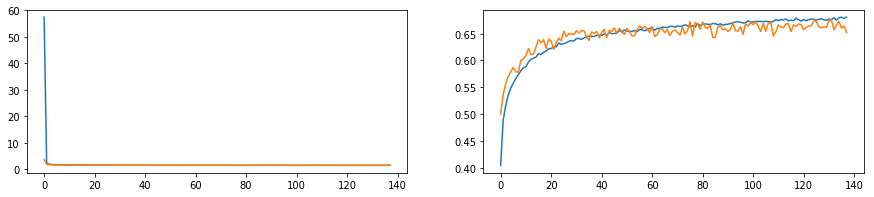

In [14]:
plt.figure(figsize=(15,3))
plt.subplot(121)
plt.plot(losses)
plt.plot(val_losses)
plt.subplot(122)
plt.plot(accs)
_ = plt.plot(val_accs)

In [18]:
max(val_accs)

0.67569998383522045